In [341]:
import json
with open('promptReduceRandomOutputs.json', 'r') as file:
    data = json.load(file)

In [342]:
import ast
a = 1600
b = 1800
gt = []
for i in range(200):
    gt.append(data[i]['testGT'])

In [343]:
pred = []
for i in range(a,b):
    pred.append(data[i]['output2'])

In [344]:
def Hit(A, test_set):
    dcg = 0
    r_i = 0
    for i in range(len(A)):
        
        if A[i] in test_set:
            r_i = 1
            return r_i
    return r_i

In [345]:
import numpy as np
import numpy as np
from sklearn.metrics import ndcg_score

def compute_precision_recall(targets, predictions, k):  
    num_hit = [pred for pred in predictions if any(pred[:int(1*len(pred))] == tar[:int(1*len(tar))] for tar in targets)]
    num_hit = len(num_hit)
    precision = float(num_hit) / len(predictions)    
    recall = float(num_hit) / len(targets)    
    return precision, recall


def NDCG(targets, predicitions):
    test_movies = list(set(movie for sublist in predicitions for movie in sublist)) # unique items
    y_score = np.zeros((len(predicitions), len(test_movies))) # convert to score
    for i, rec_list in enumerate(predicitions):
        for j, item in enumerate(test_movies):
            if item in rec_list:
                y_score[i, j] = len(test_movies) - rec_list.index(item) # get a list of scores, match and early item have higher score

    # Convert test_sets to y_true
    y_true = np.zeros((len(targets), len(test_movies)))
    for i, test_list in enumerate(targets):
        for j, item in enumerate(test_movies):
            if item in test_list:
                y_true[i, j] = 1 # if hit 1 if not 0
    return ndcg_score(y_true, y_score, k = 5)

In [346]:
import re
def texta(text):
    recommended_movies = []
    for line in text.split('\n'):
        if line.startswith(("1. ", "2. ", "3. ", "4. ", "5. ")):
            movie = re.search(r'\"(.*?)\"', line)
            if movie:
                recommended_movies.append(movie.group(1))
    return recommended_movies

In [347]:
import re
pt_movies = []
for a in range(200):
    text = pred[a]
    pattern =  r'\d+\. (.+?) -'
    recommended_movies = re.findall(pattern, text)
    if len(list(set(recommended_movies))) != 5:
        recommended_movies = re.findall(r'\d+\.\s(.*?)\s\(\d+\)', text)
        if len(list(set(recommended_movies))) != 5:
            recommended_movies = re.findall(r'\d+\.\s(.*?)\s\(Liked\)', text)
            if len(list(set(recommended_movies))) != 5:
                recommended_movies = re.findall(r'\"(.*?)\"', text)
                if len(list(set(recommended_movies))) != 5:
                    recommended_movies = texta(text)
                    if len(recommended_movies) != 5:
                        recommended_movies = re.findall(r'\"(.*?)\"', text)
                        if len(recommended_movies) != 5:
                            recommended_movies = re.findall(r'^\d\.\s(.*?)\s-', text, re.MULTILINE)
                            recommended_movies = recommended_movies[:5]
                            if len(recommended_movies) != 5:
                                recommended_movies = re.findall(r'\d\.\s(.*?)\n', text)
                                if len(recommended_movies) != 5:
                                    recommended_movies = re.findall(r'\d\.\s(.*?)(?:\n|$)', text)
                                    recommended_movies[-1] = recommended_movies[-1].replace('</s>', '')
                                    if len(recommended_movies) != 5:
                                        print(a)
    titles = [title.replace('"', '') for title in recommended_movies]
    pt_movies.append(list(set(titles)))  

160
166
172


In [348]:
m = [] 
for element in pt_movies:
    movies_no_year = [re.sub(r' \(\d{4}\)', '', movie) for movie in element]
    movies_no_score = [re.sub(r' \(\d\.\d\/10\)', '', movie) for movie in movies_no_year]
    movies_no_director = [re.sub(r' \([^)]*\)', '', movie) for movie in movies_no_score]
    movie_names = [desc.split(":")[0] for desc in movies_no_director]
    m.append(movie_names)

In [349]:
pre = 0.0
recall = 0.0
for i in range(200):
    titles = m[i]
    if titles == []:
        continue
    temp_pre, temp_recall = compute_precision_recall(gt[i],titles,1)
    pre = pre + temp_pre
    recall = recall + temp_recall
print('The NDCG@5 loss is computed to be: {}'.format(NDCG(gt,m)))
print('The pre@5 loss is computed to be: {}'.format(pre /200))
print('The recall@5 loss is computed to be: {}'.format(recall/200))

The NDCG@5 loss is computed to be: 0.35695670831224097
The pre@5 loss is computed to be: 0.3256666666666671
The recall@5 loss is computed to be: 0.17537658772664244


In [351]:
# These are coming from above by change a,b +200 each interval
ndcg = [0.24909222678655435,0.28053875981583526,0.3051968072313468,0.3233537967415029,0.3288377726906373,0.3299680933939095,0.34378503720035,0.3551788651037631,0.35695670831224097,0.3708] 
pre2 = [0.21391666666666695,0.2325000000000004,0.2656666666666671,0.2767500000000004,0.2855000000000004,0.29500000000000054,0.3163333333333338, 0.3145000000000004,0.3256666666666671,0.3337]
recall2 = [0.15232117686263666,0.15053373530690384,0.16341746937181156,0.16709813770992027,0.167318363001337,0.1738563571662843,0.17232314708609864,0.17773912807050596, 0.17537658772664244,0.1770]

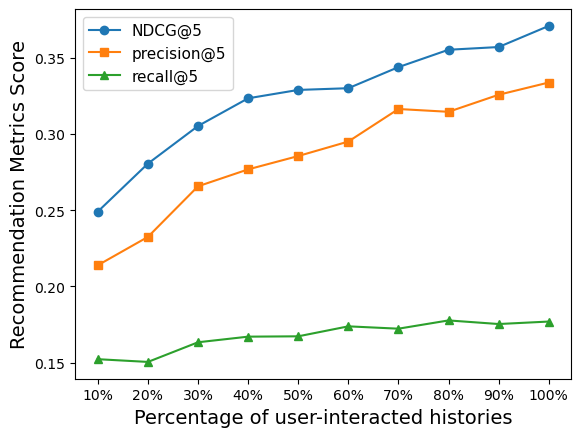

In [352]:
from matplotlib import pyplot as plt
x = ['10%','20%','30%','40%','50%','60%','70%','80%','90%','100%']
plt.plot(x, ndcg, marker='o', label='NDCG@5')
plt.plot(x, pre2, marker='s',label='precision@5')
plt.plot(x, recall2, marker='^', label='recall@5')

# Add labels and title
plt.xlabel('Percentage of user-interacted histories', fontsize=14) 
plt.ylabel('Recommendation Metrics Score', fontsize=14)  


# Add a legend
plt.legend(fontsize=11) 

# Show the plot
plt.show()